In [24]:
import os
#base_path = 'd:/'
base_path = '/home/martin/data_imaging/Muscle/'
# data path for the sherpas study
participants_data_filename = base_path + "/data_sherpas/ParticipantsDemographics.xlsx"
pelvis_mri_results_path = base_path + "/data_sherpas/ReprocessedCropped/"
lumbar_mri_results_path = base_path + "/data_sherpas/LumbarSpineReprocessed/"
output_path = base_path + "data_sherpas/statistical_analysis/"

# data path for the cto5k study
#results_cto5k_filename = "D:/Work/Publications/2025_CoreScore/DataAnalysis/CoreScore/merged_data.csv"
cto5k_participants_data_filename = base_path + "/data_cto5k_cyclists/FullStudyDemographics.xlsx"
lumbar_mri_cto5k_results_path = base_path + "/data_cto5k_cyclists/AllData/Reprocessed/"
pelvis_mri_cto5k_results_path = base_path + "/data_cto5k_cyclists/AllCroppedData/Reprocessed/"

volume_ff_filename_per_subject = "volumes_and_ffs.csv"
muscle_length_mm_filename_per_subject = "muscle_lengths_mm.csv"
column_names_pelvis = ["VOL_LGMAX", "VOL_LGMED", "VOL_LGMIN", "VOL_LTFL", "VOL_RGMAX", "VOL_RGMED", "VOL_RGMIN", "VOL_RTFL",
                "FF_LGMAX", "FF_LGMED", "FF_LGMIN", "FF_LTFL", "FF_RGMAX", "FF_RGMED", "FF_RGMIN", "FF_RTFL"]
column_names_lumbar = ["VOL_LPSOAS", "VOL_LILIACUS", "VOL_LQUADRATUS", "VOL_LM+ES", "VOL_RPSOAS", "VOL_RILIACUS", "VOL_RQUADRATUS", "VOL_RM+ES",
                       "FF_LPSOAS", "FF_LILIACUS", "FF_LQUADRATUS", "FF_LM+ES", "FF_RPSOAS", "FF_RILIACUS", "FF_RQUADRATUS", "FF_RM+ES"]

os.makedirs(output_path, exist_ok=True)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns   
import scipy.stats as stats

# Load the data for the sherpas study
data = pd.read_excel(participants_data_filename, sheet_name='Sheet1')
# Load the data for the cto5k study
data_cto5k = pd.read_excel(cto5k_participants_data_filename, sheet_name='All by Number')


In [25]:
import glob

# Get all subfolders in pelvis_mri_results_path
subfolders = [f.path for f in os.scandir(pelvis_mri_results_path) if f.is_dir()]
# For each subfolder, match to ID and add volume/ff data
for folder in subfolders:
    folder_name = os.path.basename(folder)
    # Find matching row in data
    idx = data.index[data['ID'] == folder_name]
    if not idx.empty:
        csv_path = os.path.join(folder, volume_ff_filename_per_subject)
        if os.path.exists(csv_path):
            vol_ff_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in vol_ff_df.columns:
                # Assign values to named columns using column_names_pelvis
                if col > 0 and col <= len(column_names_pelvis):
                    data.loc[idx, column_names_pelvis[col-1]] = vol_ff_df.iloc[0][col]

# Do the same for lumbar results
subfolders = [f.path for f in os.scandir(lumbar_mri_results_path) if f.is_dir()]
# For each subfolder, match to ID and add volume/ff data
for folder in subfolders:
    folder_name = os.path.basename(folder)
    # Find matching row in data
    idx = data.index[data['ID'] == folder_name]
    if not idx.empty:
        csv_path = os.path.join(folder, volume_ff_filename_per_subject)
        if os.path.exists(csv_path):
            vol_ff_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in vol_ff_df.columns:
                # Assign values to named columns using column_names_lumbar
                if col > 0 and col <= len(column_names_lumbar):
                    data.loc[idx, column_names_lumbar[col-1]] = vol_ff_df.iloc[0][col]
        csv_path = os.path.join(folder, muscle_length_mm_filename_per_subject)
        if os.path.exists(csv_path):
            length_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in length_df.columns:
                # Assign values to named columns using column_names_lumbar but replacing VOL_ with LEN_
                if col > 0 and col <= len(column_names_lumbar):
                    muscle_name = column_names_lumbar[col-1][4:]  # Remove 'VOL_' prefix
                    data.loc[idx, f'LENGTH_{muscle_name}'] = length_df.iloc[0][col]

# Save the combined data to a new CSV file
combined_data_path = os.path.join(output_path, "combined_data_nepal.csv")
data.to_csv(combined_data_path, index=False)
print(f"Combined data for sherpas saved to {combined_data_path}")

Combined data for sherpas saved to /home/martin/data_imaging/Muscle/data_sherpas/statistical_analysis/combined_data_nepal.csv


In [26]:
# Load couch to 5k data to use as a reference:
# Get all subfolders in pelvis_mri_results_path
subfolders = [f.path for f in os.scandir(pelvis_mri_cto5k_results_path) if f.is_dir()]
# For each subfolder, match to ID and add volume/ff data
for folder in subfolders:
    folder_name = os.path.basename(folder)
    # Find matching row in data
    idx = data_cto5k.index[data_cto5k['Study ID C'] == folder_name]
    if not idx.empty:
        csv_path = os.path.join(folder, volume_ff_filename_per_subject)
        if os.path.exists(csv_path):
            vol_ff_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in vol_ff_df.columns:
                # Assign values to named columns using column_names_pelvis
                if col > 0 and col <= len(column_names_pelvis):
                    data_cto5k.loc[idx, column_names_pelvis[col-1]] = vol_ff_df.iloc[0][col]

# Do the same for lumbar results
subfolders = [f.path for f in os.scandir(lumbar_mri_cto5k_results_path) if f.is_dir()]
# For each subfolder, match to ID and add volume/ff data
for folder in subfolders:
    folder_name = os.path.basename(folder)
    # Find matching row in data
    idx = data_cto5k.index[data_cto5k['Study ID C'] == folder_name]
    if not idx.empty:
        csv_path = os.path.join(folder, volume_ff_filename_per_subject)
        if os.path.exists(csv_path):
            vol_ff_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in vol_ff_df.columns:
                # Assign values to named columns using column_names_lumbar
                if col > 0 and col <= len(column_names_lumbar):
                    data_cto5k.loc[idx, column_names_lumbar[col-1]] = vol_ff_df.iloc[0][col]
        csv_path = os.path.join(folder, muscle_length_mm_filename_per_subject)
        if os.path.exists(csv_path):
            length_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in length_df.columns:
                # Assign values to named columns using column_names_lumbar but replacing VOL_ with LEN_
                if col > 0 and col <= len(column_names_lumbar):
                    muscle_name = column_names_lumbar[col-1][4:]  # Remove 'VOL_' prefix
                    data_cto5k.loc[idx, f'LENGTH_{muscle_name}'] = length_df.iloc[0][col]

# Save the combined data to a new CSV file
combined_data_path = os.path.join(output_path, "combined_data_cto5k.csv")
data_cto5k.to_csv(combined_data_path, index=False)
print(f"Combined data for cto5k saved to {combined_data_path}")

Combined data for cto5k saved to /home/martin/data_imaging/Muscle/data_sherpas/statistical_analysis/combined_data_cto5k.csv


In [27]:
# Now merge both datasets into one final dataset
# Merge ID with Study ID C columns, and then keep age, sex, height, weight, BMI, group, and all muscle data columns
# Prepare data for merging by standardizing column names
data_nepal = data.copy()
data_cto5k_renamed = data_cto5k.copy()

# Rename columns to ensure consistency
#data_nepal.rename(columns={'Sex': 'Sex', 'Age': 'Age', 'Weight': 'Weight', 'Height': 'Height', 'Group': 'Group'}, inplace=True)
# rename cto5k to match nepal
data_cto5k_renamed.rename(columns={'Study ID C': 'ID', 'Sex': 'Sex', 'Age': 'Age', 'Weight (kg)': 'Weight', 'Height (cm)': 'Height', 'Group': 'Group'}, inplace=True)

# Add source indicator
data_nepal['Source'] = 'Nepal'
data_cto5k_renamed['Source'] = 'CTO5K'

# Select common columns and concatenate
columns_to_keep = ['ID', 'Sex', 'Age', 'Weight', 'Height', 'Group', 'Source', 'LENGTH_LPSOAS'] + column_names_pelvis + column_names_lumbar
final_data = pd.concat([
    data_nepal[columns_to_keep],
    data_cto5k_renamed[columns_to_keep]
], ignore_index=True)

# Now rename Sex values 'male' into 'Male', and 'female' into 'Female'
final_data['Sex'] = final_data['Sex'].replace({'male': 'Male', 'female': 'Female'})

print(f"Final combined dataset has {len(final_data)} rows and {len(final_data.columns)} columns")
final_data_path = os.path.join(output_path, "final_combined_data.csv")
final_data.to_csv(final_data_path, index=False)

Final combined dataset has 257 rows and 40 columns


In [ ]:
muscles = ['GMAX', 'GMED', 'GMIN', 'TFL', 'PSOAS', 'ILIACUS', 'QUADRATUS', 'M+ES']
# Create filtered data with the subjects with valid data and correct naming:
filtered_data = final_data[final_data['VOL_LGMAX'].notna()].copy()
# Add column for BMI
filtered_data['BMI'] = filtered_data['Weight'] / (filtered_data['Height']/100)**2
# Compute mean FF and Volume for each muscle (averaging left and right)
for muscle in muscles:
    filtered_data[f'FF_{muscle}'] = (filtered_data[f'FF_L{muscle}'] + filtered_data[f'FF_R{muscle}']) / 2
    filtered_data[f'VOL_{muscle}'] = (filtered_data[f'VOL_L{muscle}'] + filtered_data[f'VOL_R{muscle}']) / 2
for muscle in muscles:
    filtered_data[f'NORM_VOL_{muscle}'] = filtered_data[f'VOL_{muscle}'] / filtered_data['Weight']
    # now lean normalised volume:
    filtered_data[f'LEAN_NORM_VOL_{muscle}'] = filtered_data[f'NORM_VOL_{muscle}'] * (1-filtered_data[f'FF_{muscle}'])
    # by height
    filtered_data[f'NORMH_VOL_{muscle}'] = filtered_data[f'VOL_{muscle}'] / filtered_data['Height']
    # now lean normalised volume:
    filtered_data[f'LEAN_NORMH_VOL_{muscle}'] = filtered_data[f'NORMH_VOL_{muscle}'] * (1-filtered_data[f'FF_{muscle}'])
    # by height squared
    filtered_data[f'NORMH2_VOL_{muscle}'] = filtered_data[f'VOL_{muscle}'] / filtered_data['Height']**2
    # now lean normalised volume:
    filtered_data[f'LEAN_NORMH2_VOL_{muscle}'] = filtered_data[f'NORMH2_VOL_{muscle}'] * (1-filtered_data[f'FF_{muscle}'])
# Compute total volume (sum of all muscles) for each subject
filtered_data['VOL_TOTAL'] = filtered_data[[f'VOL_{muscle}' for muscle in muscles]].sum(axis=1)
filtered_data['NORM_VOL_TOTAL'] = filtered_data['VOL_TOTAL'] / filtered_data['Weight']
# Now compute normalised volume by total volume for each muscle:
for muscle in muscles:
    filtered_data[f'REL_VOL_{muscle}'] = filtered_data[f'VOL_{muscle}'] / filtered_data['VOL_TOTAL']

# Now convert FF to percentage
ff_columns = [col for col in filtered_data.columns if col.startswith('FF_')]
filtered_data[ff_columns] = filtered_data[ff_columns] * 100

# Save csv with filtered data
filtered_data_path = os.path.join(output_path, "full_data_results_only_valid.csv")
filtered_data.to_csv(filtered_data_path, index=False)
print(f"Filtered data saved to {filtered_data_path}")
# If you want to convert volumes from mm^3 to cm^3, uncomment the following line:
#vol_columns = [col for col in filtered_data.columns if col.startswith('VOL_')]
#filtered_data[vol_columns] = filtered_data[vol_columns] / 1000  

Filtered data saved to /home/martin/data_imaging/Muscle/data_sherpas/statistical_analysis/full_data_results_only_valid.csv


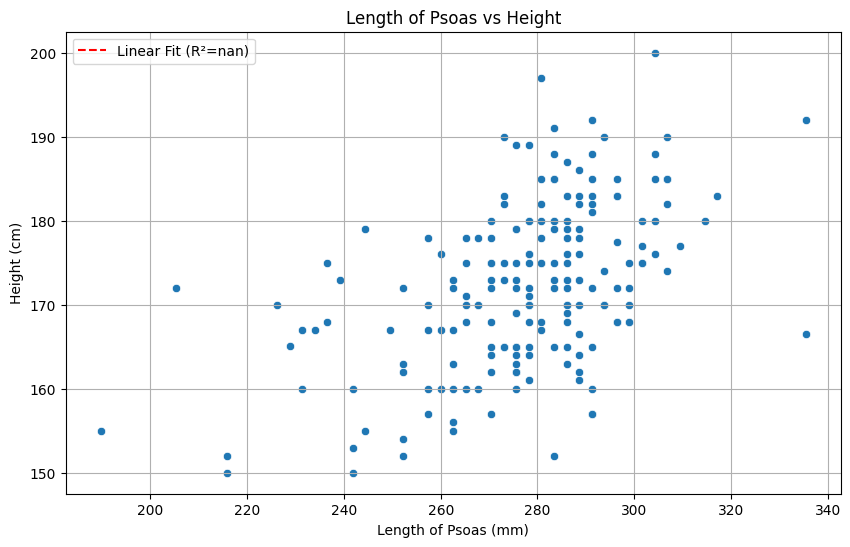

In [29]:
# Plot length of psoas vs height
# And fit a linear regression line
# Only for cto5k subjects (to avoid bias from sherpas)
cto5k_pd = filtered_data[filtered_data['Source'] == 'CTO5K'].copy()
slope, intercept, r_value, p_value, std_err = stats.linregress(cto5k_pd['LENGTH_LPSOAS'], cto5k_pd['Height'])
x_vals = np.linspace(cto5k_pd['LENGTH_LPSOAS'].min(), cto5k_pd['LENGTH_LPSOAS'].max(), 100)
y_vals = slope * x_vals + intercept
filtered_data = filtered_data[filtered_data['LENGTH_LPSOAS'] >= 200]
# Estimate Sherpa heights from their psoas length using the fitted regression model
filtered_data['Estimated_Height_from_Psoas'] = slope * filtered_data['LENGTH_LPSOAS'] + intercept

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cto5k_pd, x='LENGTH_LPSOAS', y='Height')
sns.scatterplot(x=filtered_data['LENGTH_LPSOAS'], y=filtered_data['Estimated_Height_from_Psoas'], marker='X', color='orange', label='Sherpa Estimated Height')
plt.title('Length of Psoas vs Height')
plt.xlabel('Length of Psoas (mm)')
plt.ylabel('Height (cm)')
plt.plot(x_vals, y_vals, color='red', linestyle='--', label=f'Linear Fit (R²={r_value**2:.2f})')
plt.legend()
plt.grid()
plt.show()

In [30]:
# Compute demographics:
# Compute mean (SD) for age, BMI, years post-transplant, and years of dialysis for each group
group_stats = filtered_data.groupby('Group').agg(
    Age_Mean=('Age', 'mean'),
    Age_SD=('Age', 'std'),
    Age_Min=('Age', 'min'),
    Age_Max=('Age', 'max'),
    BMI_Mean=('BMI', 'mean'),
    BMI_SD=('BMI', 'std'),
    BMI_Min=('BMI', 'min'),
    BMI_Max=('BMI', 'max'),
    #Years_Post_Transplant_Mean=('¿Cuánto tiempo hizo diálisis antes de su trasplante?\nSi no hizo diálisis, indiquelo con un 0', 'mean'),
    #Years_Post_Transplant_SD=('¿Cuánto tiempo hizo diálisis antes de su trasplante?\nSi no hizo diálisis, indiquelo con un 0', 'std'),
    #Years_Dialysis_Mean=('¿Hace cuanto tiempo que realiza diálisis?', 'mean'),
    #Years_Dialysis_SD=('¿Hace cuanto tiempo que realiza diálisis?', 'std'),
    Subject_Count=('Group', 'count')
    , Male_Count=('Sex', lambda x: (x == 'Male').sum()),
    Female_Count=('Sex', lambda x: (x == 'Female').sum()),
    Male_Percentage=('Sex', lambda x: (x == 'Male').mean() * 100),
    Female_Percentage=('Sex', lambda x: (x == 'Female').mean() * 100)
)

# Print the computed statistics
print(group_stats)

           Age_Mean     Age_SD  Age_Min  Age_Max       BMI_Mean        BMI_SD  \
Group                                                                           
ACT10     59.500000   9.607289     41.0     69.0      29.037267      4.631146   
C25K      43.025000  13.838101     19.0     65.0      28.650066      6.009119   
C25Kpost  47.100000  15.272611     21.0     65.0      26.636274      3.937971   
Cyclists  43.275862  10.070322     24.0     68.0      23.051260      2.417719   
Kayaker   71.428571   4.157609     66.0     78.0  223195.645623   3201.701837   
Porter    36.860465   8.470063     21.0     55.0  249648.045600  25130.369106   

                BMI_Min        BMI_Max  Subject_Count  Male_Count  \
Group                                                               
ACT10         24.000000      35.497867              6           3   
C25K          18.645344      54.869684             80          41   
C25Kpost      21.295295      34.375000             20          13   
Cyclis

In [31]:
# Keep only Porter, C25K and Cyclists groups, only males and between 18 and 52 years old
filtered_data_analysis = filtered_data[(filtered_data['Group'].isin([ 'Porter','C25K', 'Cyclists'])) &
                               (filtered_data['Sex'] == 'Male') &
                               (filtered_data['Age'] >= 18) &
                               (filtered_data['Age'] <= 52)]
# --- IGNORE ---
print(f"Filtered data for analysis has {len(filtered_data_analysis)} rows and {len(filtered_data_analysis.columns)} columns")
# --- IGNORE ---    
# Now save the filtered data again
filtered_data_path = os.path.join(output_path, "filtered_data_for_sherpas_paper_analysis.csv")
filtered_data_analysis.to_csv(filtered_data_path, index=False)

# Recompute demographics for the filtered data
group_stats_filtered = filtered_data_analysis.groupby('Group').agg(
    Age_Mean=('Age', 'mean'),
    Age_SD=('Age', 'std'),
    Age_Min=('Age', 'min'),
    Age_Max=('Age', 'max'),
    BMI_Mean=('BMI', 'mean'),
    BMI_SD=('BMI', 'std'),
    BMI_Min=('BMI', 'min'),
    BMI_Max=('BMI', 'max'),
    Subject_Count=('Group', 'count'),
    Male_Count=('Sex', lambda x: (x == 'Male').sum()),
    Female_Count=('Sex', lambda x: (x == 'Female').sum()),
    Male_Percentage=('Sex', lambda x: (x == 'Male').mean() * 100),
    Female_Percentage=('Sex', lambda x: (x == 'Female').mean() * 100)
)
# Print the computed statistics
print(group_stats_filtered)

Filtered data for analysis has 98 rows and 109 columns
           Age_Mean    Age_SD  Age_Min  Age_Max       BMI_Mean        BMI_SD  \
Group                                                                          
C25K      34.689655  9.513537     21.0     51.0      29.108287      4.863110   
Cyclists  40.428571  8.364070     24.0     52.0      23.871156      2.423207   
Porter    36.292683  8.130941     21.0     52.0  249269.302446  25375.785680   

                BMI_Min        BMI_Max  Subject_Count  Male_Count  \
Group                                                               
C25K          19.591837      39.605035             29          29   
Cyclists      18.518519      30.991736             28          28   
Porter    213039.485767  320512.820513             41          41   

          Female_Count  Male_Percentage  Female_Percentage  
Group                                                       
C25K                 0            100.0                0.0  
Cyclists       

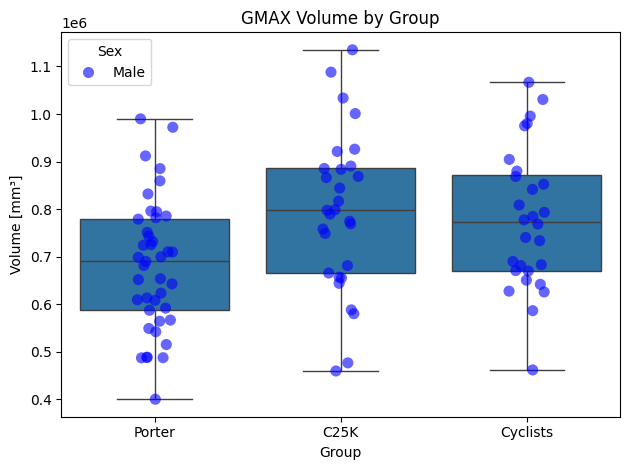

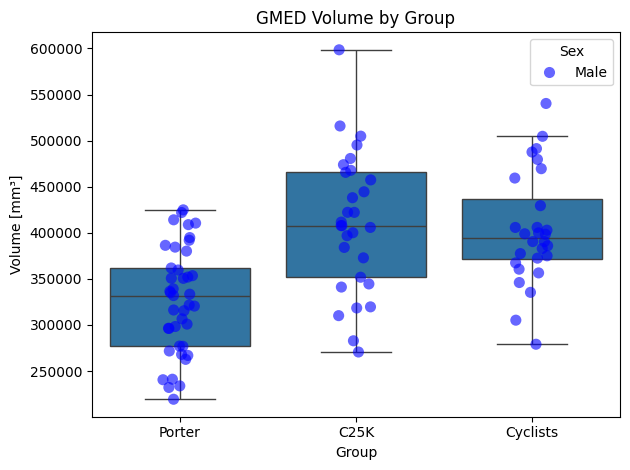

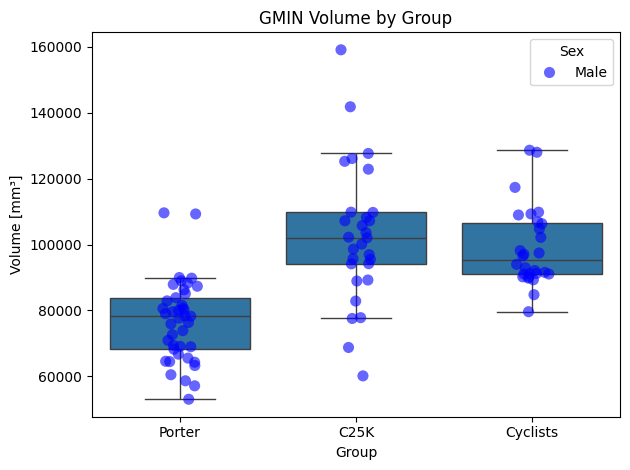

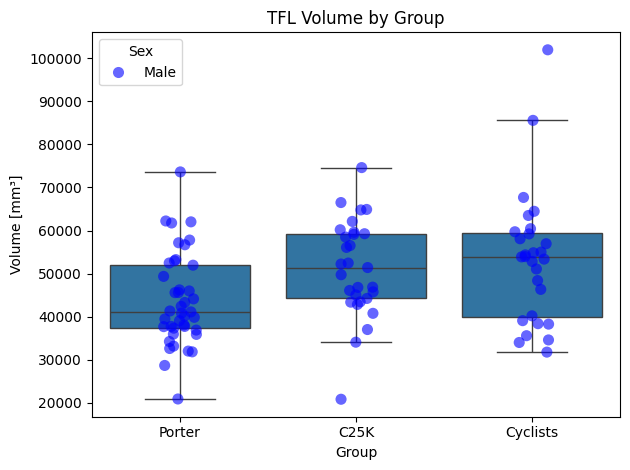

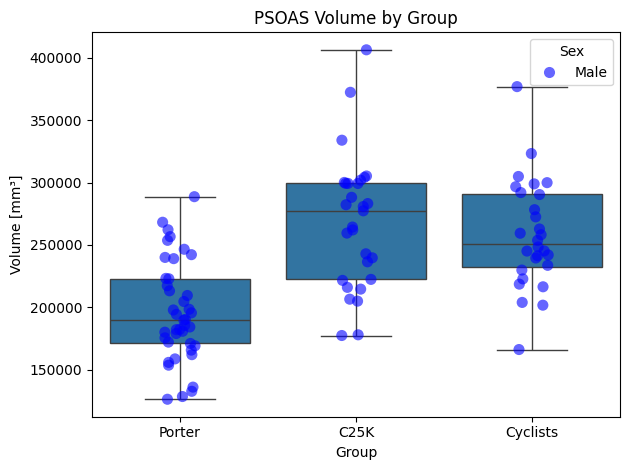

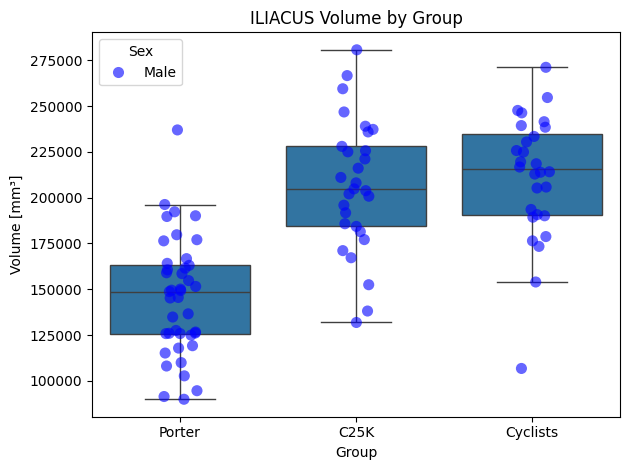

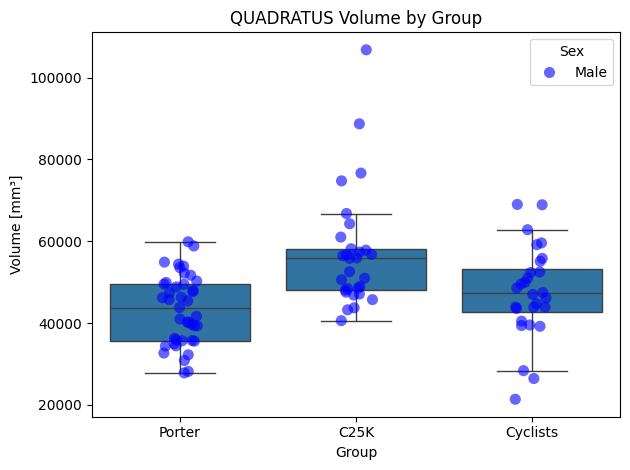

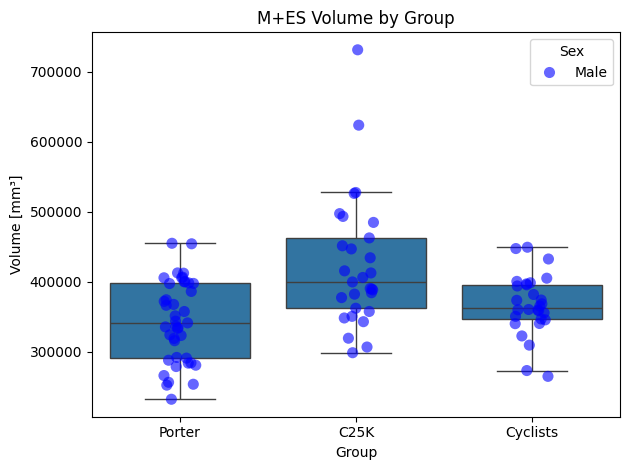

In [36]:
# Plot box plots for volume:

for muscle in ['GMAX', 'GMED', 'GMIN', 'TFL', 'PSOAS', 'ILIACUS', 'QUADRATUS', 'M+ES']:
    sns.boxplot(x='Group', y=f'VOL_{muscle}', data=filtered_data_analysis, showfliers=False)
    sns.stripplot(x='Group', y=f'VOL_{muscle}', data=filtered_data_analysis, hue='Sex', 
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if filtered_data_analysis['Sex'].iloc[0] == 'Male' else 'X')
    plt.ylabel('Volume [mm³]')
    plt.title(f'{muscle} Volume by Group')
    #plt.ylim(0, 25)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_vol_{muscle}_by_group.png"))
    plt.show()
    plt.close()


In [37]:
# Plot box plots for volume relative to total volume:

for muscle in ['GMAX', 'GMED', 'GMIN', 'TFL', 'PSOAS', 'ILIACUS', 'QUADRATUS', 'M+ES']:

    sns.boxplot(x='Group', y=f'VOL_{muscle}'/filtered_data_analysis['VOL_TOTAL'], data=filtered_data_analysis, showfliers=False)
    sns.stripplot(x='Group', y=f'VOL_{muscle}'/filtered_data_analysis['VOL_TOTAL'], data=filtered_data_analysis, hue='Sex', 
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if filtered_data_analysis['Sex'].iloc[0] == 'Male' else 'X')
    plt.ylabel('Volume [mm³]')
    plt.title(f'{muscle} Volume by Group')
    #plt.ylim(0, 25)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_vol_{muscle}_by_group.png"))
    plt.show()
    plt.close()

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [33]:
# CREATE MELTED DATAFRAME WITH ALL MUSCLES AND VARIABLES
# Create dataframes for each variable
ff_cols = [f'FF_{muscle}' for muscle in muscles]
vol_cols = [f'VOL_{muscle}' for muscle in muscles]
nvol_cols = [f'NORM_VOL_{muscle}' for muscle in muscles]
lnvol_cols = [f'LEAN_NORM_VOL_{muscle}' for muscle in muscles]
nhvol_cols = [f'NORMH_VOL_{muscle}' for muscle in muscles]
lnhvol_cols = [f'LEAN_NORMH_VOL_{muscle}' for muscle in muscles]
nh2vol_cols = [f'NORMH2_VOL_{muscle}' for muscle in muscles]
lnh2vol_cols = [f'LEAN_NORMH2_VOL_{muscle}' for muscle in muscles]
ff_df = filtered_data[ff_cols].copy()
vol_df = filtered_data[vol_cols].copy()
nvol_df = filtered_data[nvol_cols].copy()
lnvol_df = filtered_data[lnvol_cols].copy()
nhvol_df = filtered_data[nhvol_cols].copy()#
lnhvol_df = filtered_data[lnhvol_cols].copy()
nh2vol_df = filtered_data[nh2vol_cols].copy()
lnh2vol_df = filtered_data[lnh2vol_cols].copy()


# now melt all dataframes and concatenate them
# now melt it
ff_melted = ff_df.melt(var_name='Muscle', value_name='FF')
ff_melted['Muscle'] = ff_melted['Muscle'].str.replace('FF_', '')
vol_melted = vol_df.melt(var_name='Muscle', value_name='VOL')
vol_melted['Muscle'] = vol_melted['Muscle'].str.replace('VOL_', '')
nvol_melted = nvol_df.melt(var_name='Muscle', value_name='NORM_VOL')
nvol_melted['Muscle'] = nvol_melted['Muscle'].str.replace('NORM_VOL_', '')
lnvol_melted = lnvol_df.melt(var_name='Muscle', value_name='LEAN_NORM_VOL')
lnvol_melted['Muscle'] = lnvol_melted['Muscle'].str.replace('LEAN_NORM_VOL_', '')
nhvol_melted = nhvol_df.melt(var_name='Muscle', value_name='NORMH_VOL')
nhvol_melted['Muscle'] = nhvol_melted['Muscle'].str.replace('NORMH_VOL_', '')
lnhvol_melted = lnhvol_df.melt(var_name='Muscle', value_name='LEAN_NORMH_VOL')
lnhvol_melted['Muscle'] = lnhvol_melted['Muscle'].str.replace('LEAN_NORMH_VOL_', '')
nh2vol_melted = nh2vol_df.melt(var_name='Muscle', value_name='NORMH2_VOL')
nh2vol_melted['Muscle'] = nh2vol_melted['Muscle'].str.replace('NORMH2_VOL_', '')
lnh2vol_melted = lnh2vol_df.melt(var_name='Muscle', value_name='LEAN_NORMH2_VOL')
lnh2vol_melted['Muscle'] = lnh2vol_melted['Muscle'].str.replace('LEAN_NORMH2_VOL_', '')
# Concatenate all melted dataframes
all_melted = pd.concat([ff_melted, vol_melted['VOL'], nvol_melted['NORM_VOL'], lnvol_melted['LEAN_NORM_VOL'],
                        nhvol_melted['NORMH_VOL'], lnhvol_melted['LEAN_NORMH_VOL'],
                        nh2vol_melted['NORMH2_VOL'], lnh2vol_melted['LEAN_NORMH2_VOL']], axis=1)

# Repeat sex and group info to match melted data
n = len(muscles) # Number of times to repeat each row (e.g., number of muscles)
repeated_info = pd.concat([filtered_data[['Sex', 'Group']]] * n, ignore_index=True)
all_melted[['Sex', 'Group']] = repeated_info
all_melted.to_csv(os.path.join(output_path, "ff_melted_by_muscle_and_group.csv"), index=False)


/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


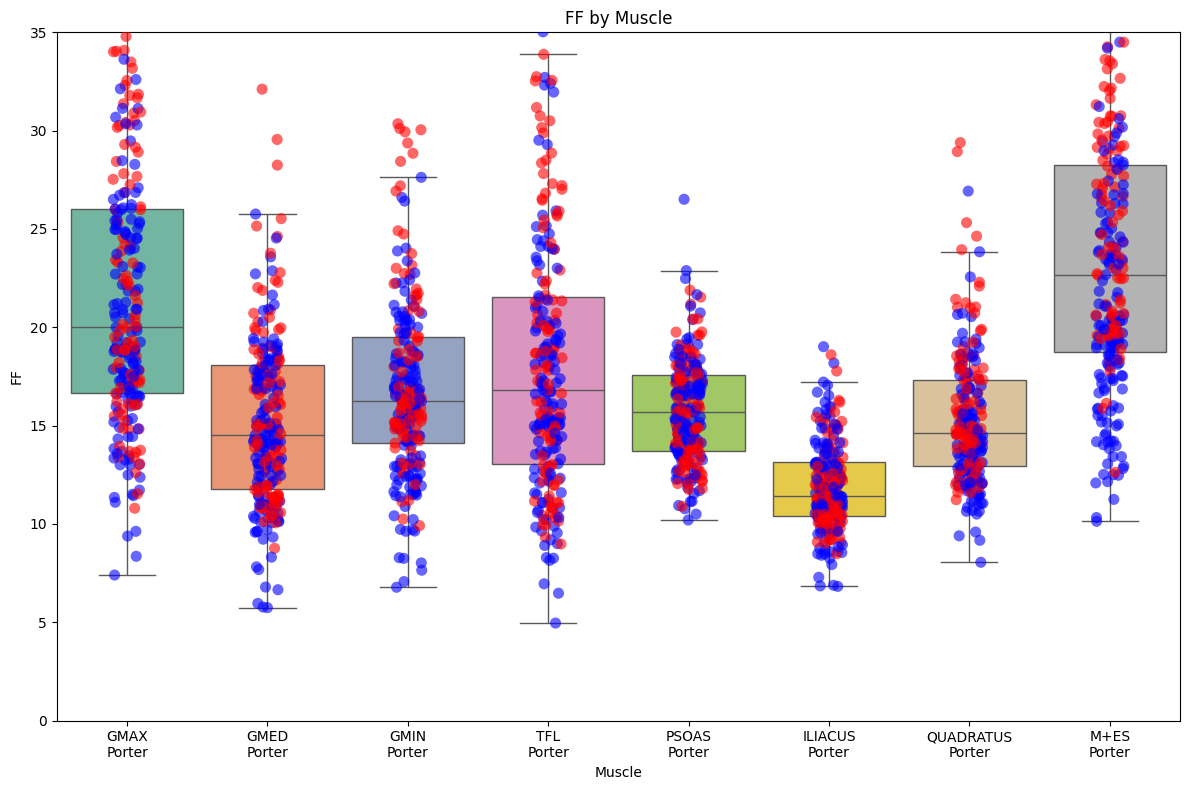

/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


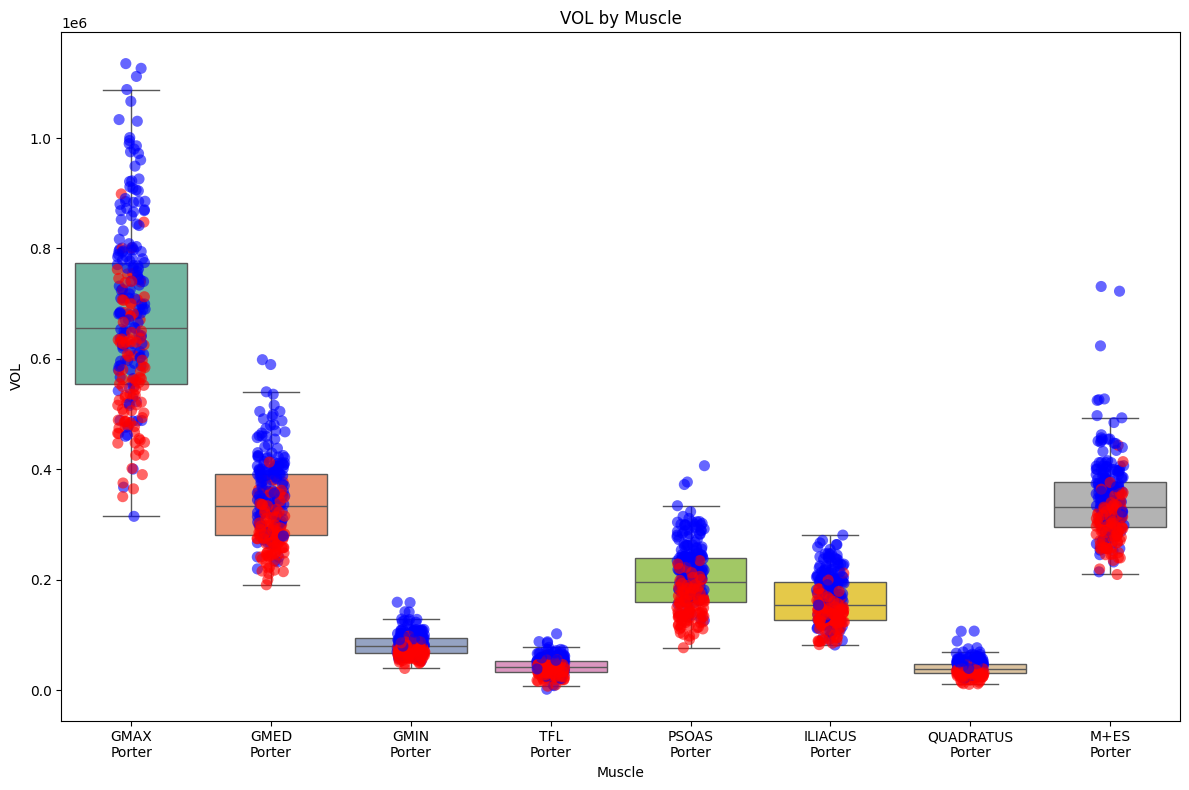

/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


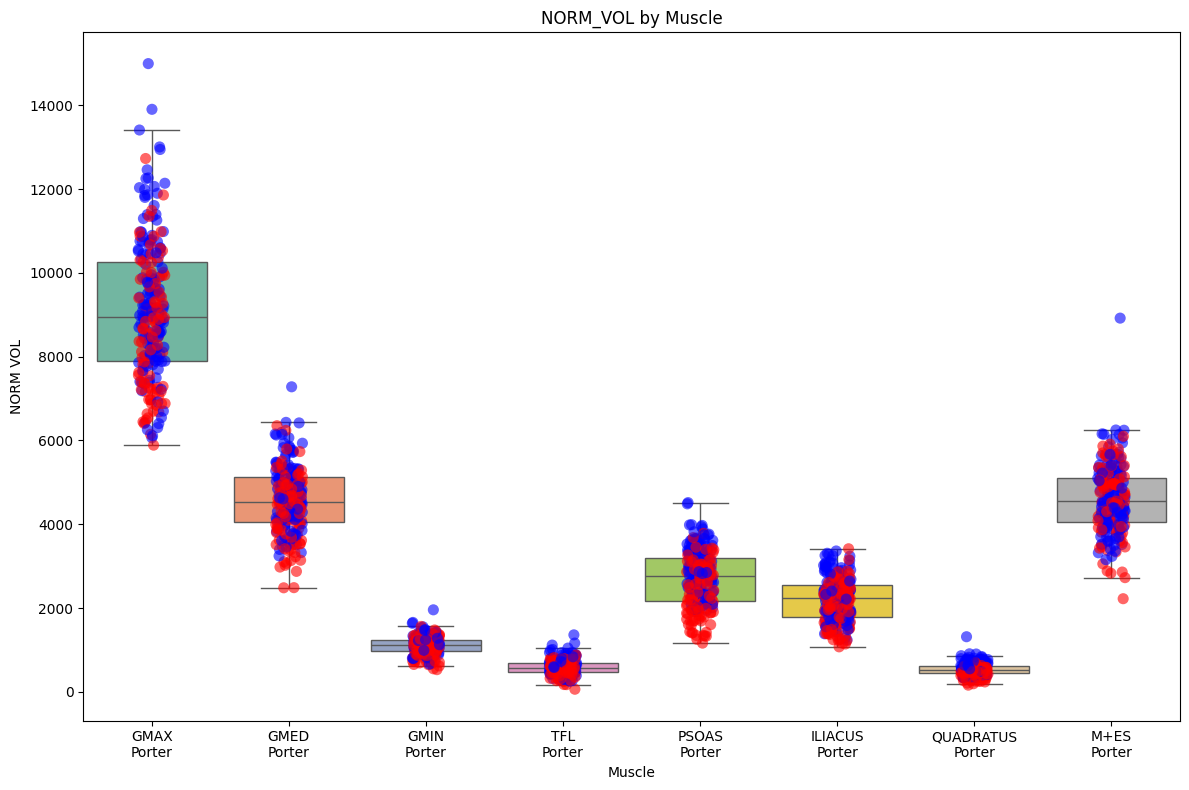

/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


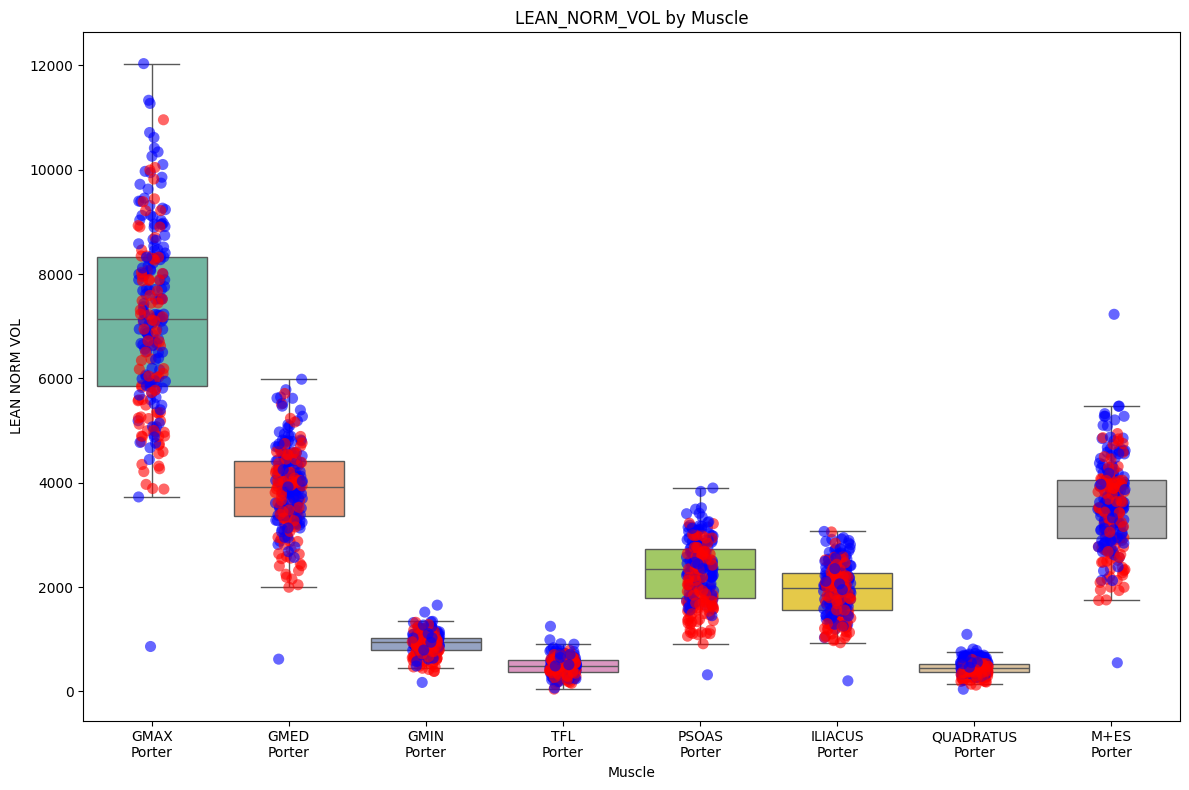

/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


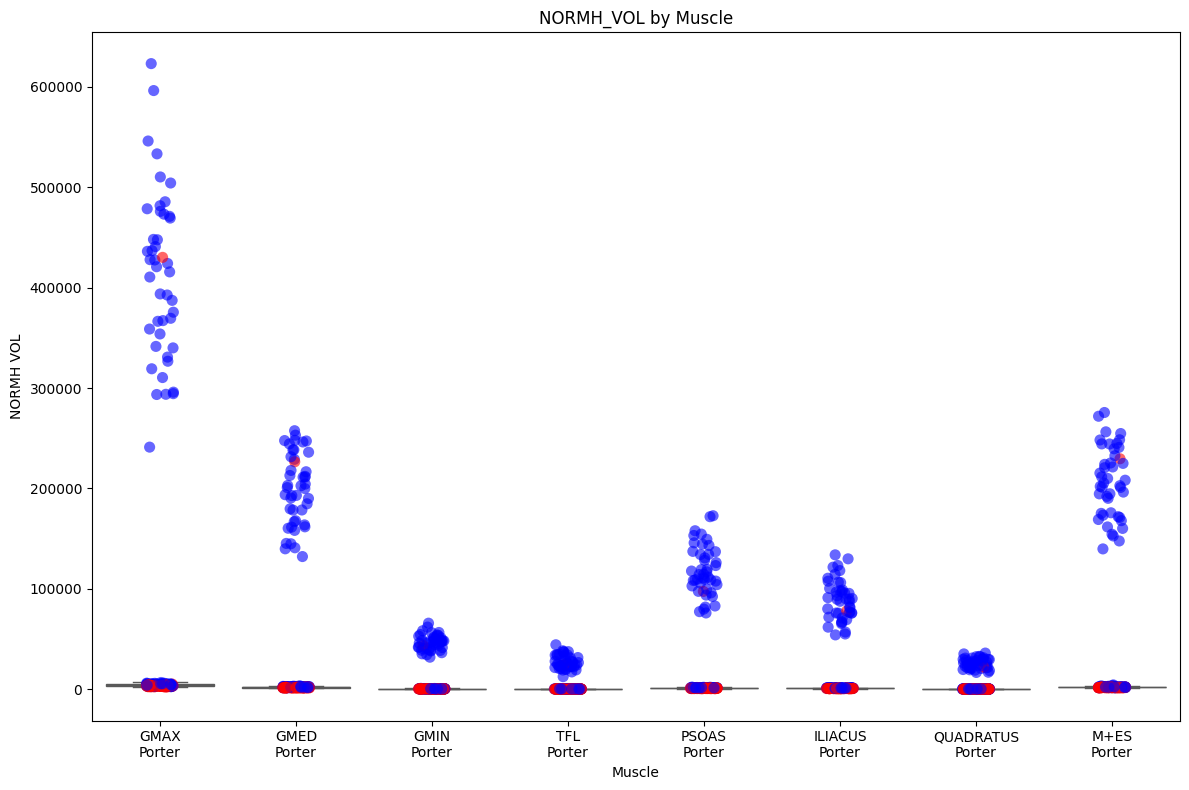

/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


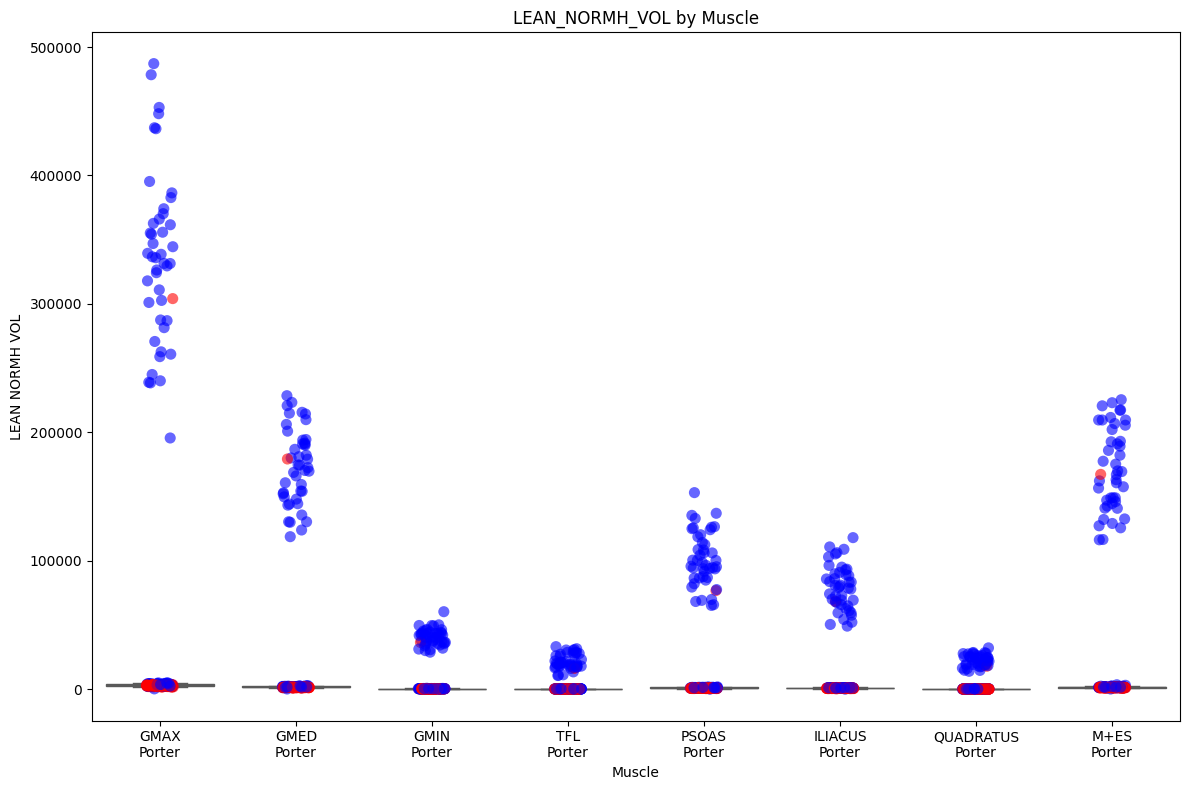

/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


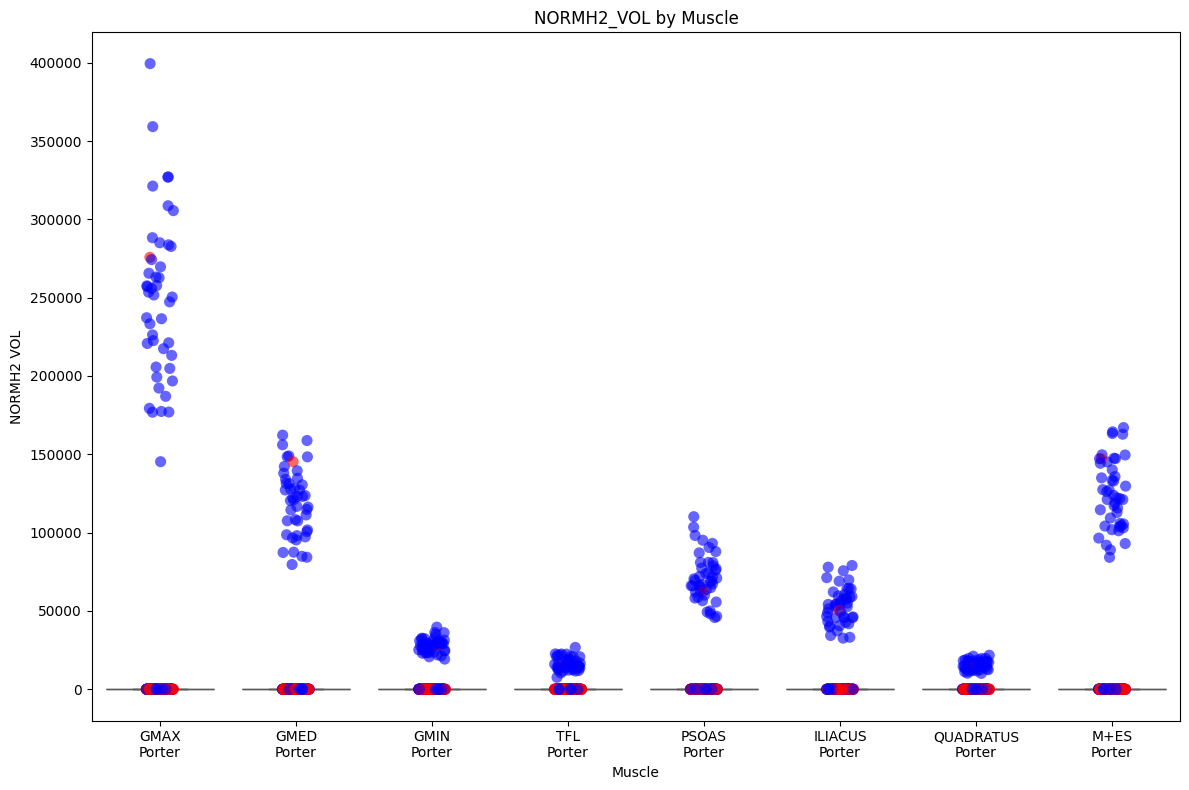

/tmp/ipykernel_3223021/2861300910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
/tmp/ipykernel_3223021/2861300910.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


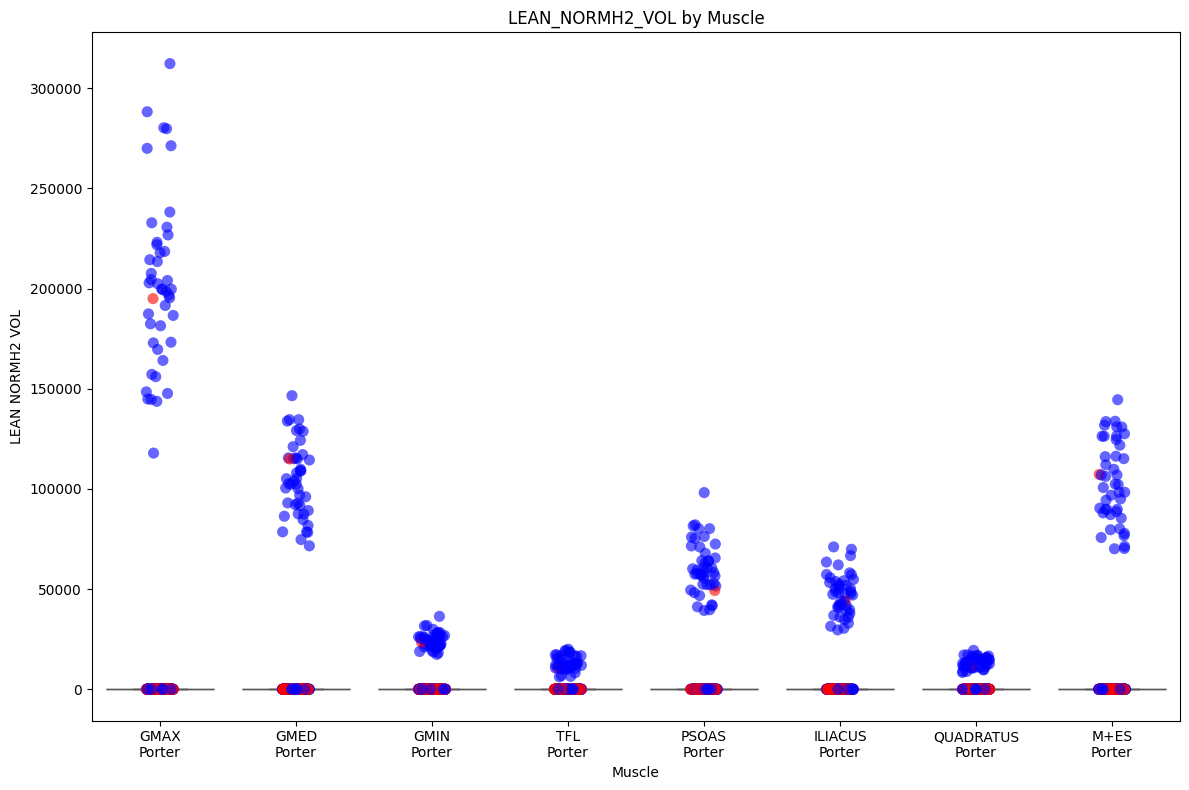

/tmp/ipykernel_3223021/2861300910.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y='FF', data=all_melted, showfliers=False, palette='Set2')


NameError: name 'i' is not defined

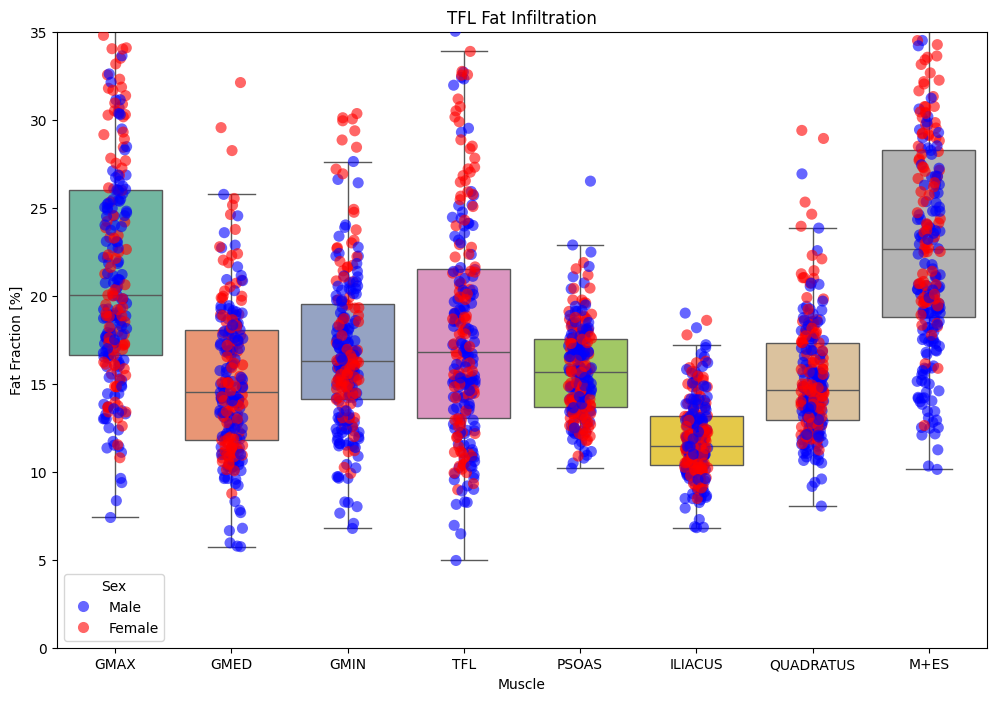

In [34]:

variables = ['FF', 'VOL', 'NORM_VOL', 'LEAN_NORM_VOL', 'NORMH_VOL', 'LEAN_NORMH_VOL', 'NORMH2_VOL', 'LEAN_NORMH2_VOL']
melted_dfs = {
    'FF': all_melted[['Muscle', 'FF', 'Sex', 'Group']],
    'VOL': vol_melted.join(repeated_info),
    'NORM_VOL': nvol_melted.join(repeated_info),
    'LEAN_NORM_VOL': lnvol_melted.join(repeated_info),
    'NORMH_VOL': nhvol_melted.join(repeated_info),
    'LEAN_NORMH_VOL': lnhvol_melted.join(repeated_info),
    'NORMH2_VOL': nh2vol_melted.join(repeated_info),
    'LEAN_NORMH2_VOL': lnh2vol_melted.join(repeated_info)
}
muscle_order = muscles
for var in variables:
    df = melted_dfs[var]
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
    sns.stripplot(x='Muscle', y=var, data=df, hue='Sex',
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8,
                  marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X', dodge=False, ax=ax)
    ax.set_ylabel(var.replace('_', ' '))
    ax.set_title(f'{var} by Muscle')
    ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])
    if var == 'FF':
        ax.set_ylim(0, 35)
    if ax.get_legend():
        ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_{var.lower()}_all_muscles_by_group.png"))
    plt.show()
# Plot box plots for fat fraction:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='Muscle', y='FF', data=all_melted, showfliers=False, palette='Set2')
sns.stripplot(x='Muscle', y='FF', data=all_melted, hue='Sex',
                palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8,
                marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X', dodge=False)
ax.set_ylabel('Fat Fraction [%]')
ax.set_title(f'{muscle} Fat Infiltration')
ax.set_ylim(0, 35)
if i == 0:
    ax.legend(title='Sex')
else:
    ax.get_legend().remove()
plt.tight_layout()
plt.savefig(os.path.join(output_path, "boxplot_ff_all_muscles_by_group.png"))
plt.show()



In [ ]:
# Merge cto5k_pd and filtered_data for TFL muscle, renaming cto5k_pd columns to match Sherpa columns

# Prepare cto5k_pd subset for TFL
cto5k_pd_tfl = cto5k_pd[['age_years', 'group', 'TFL', 'sex']].copy()
cto5k_pd_tfl.rename(columns={
    'age_years': 'Age',
    'group': 'Group',
    'TFL': 'FF_TFL',
    'sex': 'Sex'
}, inplace=True)

# Prepare filtered_data subset for TFL
sherpa_tfl = filtered_data[['Age', 'Group', 'FF_TFL', 'Sex']].copy()

# Concatenate both dataframes
merged_tfl = pd.concat([cto5k_pd_tfl, sherpa_tfl], ignore_index=True)

print(merged_tfl.head())

In [ ]:

# Plot violin plots with individual dots for each variable
for i, variable in enumerate(variables_to_plot, 1):
    plt.subplot(2, 3, i)  # Create a subplot grid
    #sns.violinplot(x='group', y=variable, data=cto5k_pd_copy, palette='muted', inner=None, hue='group', split=False)
    sns.boxplot(x='group', y=variable, data=cto5k_pd, showfliers=False, palette='Set2')
    sns.stripplot(x='group', y=variable, data=cto5k_pd, hue='sex', 
                  palette={'male': 'blue', 'female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if cto5k_pd['sex'].iloc[0] == 'male' else 'X')
    #sns.stripplot(x='group', y=variable, data=cto5k_pd_copy, color='black', alpha=0.6, jitter=True)
    #sns.violinplot(x='Group', y='FF_GMAX', data=filtered_data, palette='muted', inner=None)
    plt.title(f'{variables_names_for_titles[variable]}')
    plt.xlabel('Group')
    plt.ylabel(f'{ylabel_names[variable]}')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(output_path + "violin_plots_core_score_group.png")
plt.show()

In [ ]:
variables_to_plot = ['GMAX', 'GMED', 'GMIN','TFL']
cto5k_pd['sex'] = cto5k_pd['sex'].replace({'male': 'Male', 'female': 'Female'})
for variable in variables_to_plot:
    # Concatenate the two dataframes and keep only three columns
    concatenated_table = pd.concat([
        cto5k_pd[['age_years', 'group', f'{variable}', 'sex']].rename(columns={'age_years': 'Age', 'group': 'Group', f'{variable}': 'Fat Fraction', 'sex': 'Sex'}),
        filtered_data[['Age', 'Group', f'FF_{variable}', 'Sex']].rename(columns={f'FF_{variable}': 'Fat Fraction'})
    ], ignore_index=True)
    print(concatenated_table)
    # Fit a linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(cto5k_pd['age_years'], cto5k_pd[f'{variable}'])
    # Add the regression line to the plot
    x_vals = np.linspace(18, filtered_data['Age'].max()+5, 100)
    y_vals = slope * x_vals + intercept
    print(f"Muscle: {variable}, R²: {r_value**2:.2f}, Slope: {slope:.4f}, R: {r_value:.4f}, Error? {std_err:.4f}")
   # print(x_vals)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Age', y=f'Fat Fraction', data=concatenated_table, hue='Group', style='Sex', palette='Set2', s=100)
    #sns.scatterplot(x='Age', y=f'FF_{variable}', data=filtered_data, hue='Group', style='Sex', palette='Set1', s=100)
    plt.plot(x_vals, y_vals, color='black', linestyle='--', label=f'Linear Fit (R²={r_value**2:.2f})')
    plt.xlabel('Age')
    plt.ylabel(f'Fat Fraction {variable} [%]')
    plt.xlim(18, filtered_data['Age'].max()+5)
    plt.ylim(0, 35)
    plt.legend()
    plt.title(f'{variable} Fat Fraction vs Age')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"scatter_ff_{variable}_vs_age.png"))
    plt.show()

In [ ]:
for muscle in ['GMAX', 'GMED', 'GMIN', 'TFL']:
    sns.boxplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, showfliers=False, palette='Set2')
    sns.stripplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, hue='Sex', 
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X')
    plt.ylabel('Lean Volume [mm³/Kg]')
    plt.title(f'{muscle} Normalised Lean Volume by Group with Data Points')
    #plt.ylim(0, 25)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_lean_vol_{muscle}_by_group.png"))
    plt.show()
    plt.close()
